# Semester Project


## Imports


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import deque, namedtuple
from IPython.display import clear_output
from matplotlib import colors
from scipy.io import loadmat
from tqdm import tqdm
from decimal import Decimal

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import numpy as np


import random
import pickle
import copy
import time
import math
from itertools import combinations


## Utility Functions

### Init Functions


In [ ]:
def creation_u(n_states) :
    # Creates a matrix u of related content
    u = np.array([ [random.uniform(0,1) for i in range(n_states)] for j in range(n_states)])
    np.fill_diagonal(u, 0)
    return np.array(u)

def creation_caching(n_states, n_cached) :
    # Returns a list which contains the cost to get a content
    # It contains only 0 (cached) or 1 (non-cached)
    # Create cost of 1 and then set n of them to 0 randomly
    cost = np.ones((n_states,), dtype=int) 
    cost[random.sample(range(0, n_states), n_cached)] = 0
    return cost

def create_priori_popularity(n_states, uniform=True, start=0, end=-1) :
    """
    It creates a list of probability to get the content
    This is p_0 = [ p_0, ..., p_K-1]
    The sum should be one
    """
    #start, end used to restrict choice in a subset of items (simulation of genres)
    if end == -1:
      end=n_states
    size = end-start
    result=[]
    if uniform:
      result = np.hstack((np.hstack(([0 for i in range(0,start)], [1/size for i in range(start, end)])),[0 for i in range(end, n_states)]))
    else:
      result = np.hstack((np.hstack(([0 for i in range(0,start)], [random.random() for i in range(start, end)])),[0 for i in range(end, n_states)]))
      sum_r = np.sum(result)
      result = result/sum_r
    """
    OLD VERSION
    if uniform : 
        result = (1/n_states) * np.ones((1,n_states))[0]
    else :
        result = [random.random() for i in range(1,n_states)]
        sum_r = np.sum(result)
        result = [i/sum_r for i in result]
        result = np.array(result)
    return result
    """
    return result

def get_random_state(p0) :
    """ 
    Returns a random content among the contents
    """
    # too complicated with -> return random.randint(0, len(p0))
    state = [i for i in range(len(p0))]
    return np.random.choice(state,1,p=p0)[0]


def get_recommended(state, n_recommended, u) :
    """
    Returns the n_recommended content of the content 'state'
    For the moment we only return the most related contents
    """
    liste = u[state]
    not_null = len(np.where(liste != 0)[0])
    indx = (-liste).argsort()[:min(not_null, n_recommended)]
    return np.array(indx)

def get_cached(state, cost):
    """
    Takes as input a state and the cost matrix (where Xi = 0 if cached and 1 if not-cached)
    Returns a boolean which says whether or not it is cached or not
    """
    return cost[state] == 0


def running_mean(x, N): # controll if needed
    """
    Compute the running mean of size N
    """ 
    mask=np.ones((1,N))/N
    mask=mask[0,:]
    result = np.convolve(x,mask,'same')
    return result



def get_matrix_rewards(env) :
    # Compute the reward for each state and action
    q_table = np.zeros((env.n_states,env.n_actions))
    index_cached = np.where(env.get_index_cached() == 0)[0]
    index_recommended = env.get_index_recommendation()
    q_table[:,index_cached] += 1
    for index,x in enumerate(index_recommended) :
        q_table[index, x] +=1

    return q_table


def get_q_table_gamma(gamma_q_tables, gammas) :
    liste_title = ['Gamma = {:.2f}'.format(i) for i in gammas]
    plot_multiple(gamma_q_tables,4,3, "Actions", "States",\
                           "Q table for different values of gamma" ,\
                       liste_titles= liste_title,sizes = (10,10))

def running_mean(x, N):
  """
  Return the running mean of an array
  """
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / N

### Plotting Functions

In [ ]:
def plot_notated_matrix(matrix, title='Correlation Matrix', x_label=None, y_label=None, save_to_png=False, 
                 color_range='viridis', fig_size=(5, 5), lim=0.7, rotation_x=0, size_number=10):
    """
    Print a matrix and return the figure, axis and colorbar
    """
        
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(matrix, cmap=color_range)
  
    #Set names and grid
    size = matrix.shape[0]
    col_names = [c for c in range(size)]
    ax.set_xticks(np.arange(size))
    ax.set_yticks(np.arange(size))
    ax.set_xticklabels(col_names, rotation=rotation_x)
    ax.set_yticklabels(col_names)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.grid(False)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(x_label)
    # Remove edges
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
  
    #Add Values
    for i in range(size):
        for j in range(size):
            if matrix[i, j] > lim:
                col = 'black'
            else:
                col = 'w'
        
            text = ax.text(j, i, f'{matrix[i, j]:.2f}',
                                ha="center", va="center", color=col, fontsize=size_number)
        
    ax.set_title(title)

    #Color Bar
    cb = fig.colorbar(cm.ScalarMappable(norm=None, cmap=color_range), ax=ax, fraction=0.046, pad=0.04)
    cb.mappable.set_clim((int(np.min(matrix)), math.ceil(np.max(matrix))))
    
    fig.tight_layout()
    if save_to_png:
        plt.savefig(f"{title}.png", dpi=240)
    else:
        plt.show()
    
    return fig, ax, cb


## Define the Plot functions and the ones used for initialisation


TO BE REFACTORED

plot_q_table() is now a function of the QLearningTable class

In [ ]:
def plot_multiple(matrices,Nr,Nc, x_label, y_label,title, liste_titles,sizes = (12,12), cmap = 'viridis') :
    fig, axs = plt.subplots(Nr, Nc, figsize=sizes)
    fig.suptitle(title)

    images = []
    
    axs = axs.reshape(-1,1)
    
    for k,ax in enumerate(axs) : 
        images.append(ax[0].imshow(matrices[k], cmap=cmap))
        ax[0].label_outer()
        ax[0].set_xlabel(x_label)
        ax[0].set_ylabel(y_label)
        ax[0].set_title(liste_titles[k], fontsize = 12)
            

    vmin = 0
    vmax = 2
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.05)
    plt.show()

def get_final_table(q_table, binary = True) :
    # Retuns the final recommendation which is the policy
    indexes_max = get_max_q_table(q_table)
    final_table = np.zeros(q_table.shape)
    for index,x in enumerate(indexes_max) :
        for y in x:
            if binary :
                final_table[index,y ] = 1
            else :
                final_table[index,y ] = q_table[index,y ]


    return final_table


    
def compare_algo(env, q_table, policy, cmap, name=None ) :
    
    final_table = get_final_table(q_table, binary = True)
    
    
    to_plot = [policy,final_table, get_matrix_rewards(env),\
              policy + final_table]
    titles = ["Policy with paper algorithm","Policy with RL algorithm", 'Reward matrix','Sum of two policies']
    plot_multiple(to_plot, 2,2, "Actions", "States","", titles,sizes = (8,8), cmap=cmap)
    similarity = np.where(policy + final_table == 2 )[0].shape[0]/ q_table.shape[0]
    print("Similarity between Paper algorithm and RL algorithm : {}".format(similarity))
    
    
    
def get_max_q_table(q_table) :
    # Returns a list of indexes of the max of the q_table
    liste_index = []
    for i in range(q_table.shape[0]) :
        maxm = np.max(q_table[i])
        indexes = np.where(q_table[i] == maxm)[0]
        liste_index.append(indexes)

    return liste_index

def plot_reward_loss_gamma(
    reward,
    run_mean = 10, 
    gammas = [0,0.9],
    name='Rewards'
    ) :
    
    """
    Plot the reward for different gamam values

    ....

    Parameters
    -----------
      Reward : list of rewards
      Gammas : list of gammas used
      Run_mean : size of the window to average
    """

    colors = ['r','b', 'g', 'p']
    
    for index, gamma in enumerate(gammas) : 
        
        smoothed_rews = running_mean(reward[index], run_mean)
        
        
        plt.xlabel('Epochs')
        plt.ylabel(name)
        plt.plot(smoothed_rews, color=colors[index],\
                label = r'$\gamma$ = {}, running mean : {}'.format(gamma,run_mean))
        
        
    plt.legend()
    plt.title('{} for different values of $\gamma$'.format(name))
    plt.grid(True)
    plt.show()
        




## The Environment

methods set for single param recommended

In [ ]:
class Environment(object) :
    # Creates an environmnent
    # For us, this is the behavior of the User
    #2 types of user -> random -> alpha is coefficient to choose recommended content
    #                   qualityAware -> aplha is the quality threshold for accepting the recommended content
    def __init__(self,n_actions,  n_states, alpha, to_leave, n_recommended, n_cached,\
                rewards,SEED=5, u=None, user_type='random', choice_offset_start=0, choice_offset_end=-1) :
        self.SEED = SEED
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        # Alpha is the coefficient in which a user chooses a recommended content
        self.to_leave = to_leave
        # to_leave is the coefficient in which a user decides to quit the process
        self.n_recommended = n_recommended
        # n_recommend corresponds to the number of content to recommend. HERE, WE DON'T USE IT YET
        self.n_cached = n_cached
        # n_cached correponds to the number of cached content
        self.u = creation_u(self.n_states) if u is None else u  
        # U matrix which denotes the similarity score
        self.cost = creation_caching(self.n_states, self.n_cached)
        # It denotes the cached content (0 if cached, 1 not-cached)
        if choice_offset_end == -1:
          self.choice_offset_end=n_states
        else:
          self.choice_offset_end=choice_offset_end
        self.choice_offset_start = choice_offset_start
        self.p0 = create_priori_popularity(self.n_states, start=self.choice_offset_start, end=self.choice_offset_end)
        # The probability to choose content j from the catalogue
        self.rewards = rewards
        # List of rewards like [RC, RnC , nRC, nRnC]
        # RC = Recommended & Cached ; nRnC = non Recommended & non Cached
        self.recommended = self.get_index_recommendation()
        #set user_type
        self.user_type = user_type
        
        
    def refresh(self,SEED = None) :
        # Reset the state to a new value
        if SEED is not None :
            self.SEED = SEED
        return random.randrange(0,self.n_states,1)
    
    def reset(self) :
        # Reset the environment to a new random state. 
        #It resets both the recommendation and the cached indexes
        # It returns a first state
        self.u = creation_u(self.n_states)
        self.cached = creation_caching(self.n_states, self.n_cached)
        self.p0 = create_priori_popularity(self.n_states)
    
        return self.state[random.randrange(0,self.n_states,1)]

    
    
    def find_reward(self, state, next_state) :
        '''
        Get the current and the next state. 

        If the cost of the next state is 0 i.e it is not cached, 
        then reward is 1 if the state is in recommended matrix, otherwise 0. 

        If the state is cached only, then th reward is 1.

        If the state is both cached and recommended, then the reward is 2 .
        '''
        if ((state is None) or (next_state is None) ):
            return None 

        recommended_matrix = self.recommended[state]
        
        is_cached = get_cached (next_state, self.cost)

        if ( (next_state in recommended_matrix) and (is_cached)) :
            return self.rewards[0]
        elif ( (next_state in recommended_matrix) and ( not is_cached) ) :
            return self.rewards[1]
        elif ( (next_state not in recommended_matrix ) and (is_cached)) :
            return self.rewards[2]
        else :
            return self.rewards[3]

    
    #action is list of actions suggested
    def step(self, action, state) :
        ''' 
        Returns the state, reward after taking the action in input
        done is a boolean to say whether the user quits the game or not
        We want to return the state where will be the user when we suggest him "action"
        Knowing he is in the current 'state'
        '''
        
        if (random.uniform(0, 1) < self.to_leave) :
            # If the user stops to play -> he reward is 0 and the next state is 
            
            # reward = self.fin_reward(action, state)
            new_state, reward, done = None, 0 , True
            
            return new_state,reward, done
        else :
            # Else the user will choose among the contents
            if (self.user_type == 'random'):
                #random user -> probability alpha to follow reccommendation, but check that action != state
                if (random.uniform(0,1)< self.alpha and state not in action) :

                    # Get the new state randomly 
                    new_state = random.choice(action)
                    
                    # Get the  reward based on transition to the new state, from the current state
                    reward = self.find_reward(state, new_state)
                
                else :
                    # The user picks a content randomly in the catalogue
                    new_state = get_random_state(self.p0)
                    
                    #check to avoid self loop for multiple states 
                    while(new_state == state):
                        new_state = get_random_state(self.p0)
                    
                    reward = self.find_reward(state, new_state)

            elif (self.user_type == 'subset_interested'):
                actions_approved = list(i for i in action if i >= self.choice_offset_start and i < self.choice_offset_end)
                
                if (len(actions_approved) >0 and random.uniform(0,1)< self.alpha and state not in action) :
                    # Get the new state randomly 
                    new_state = random.choice(actions_approved)
                    
                    # Get the  reward based on transition to the new state, from the current state
                    reward = self.find_reward(state, new_state)
                
                else :
                    # The user picks a content randomly in the catalogue
                    new_state = get_random_state(self.p0)
                    
                    #check to avoid self loop for multiple states 
                    while(new_state == state):
                        new_state = get_random_state(self.p0)
                    
                    reward = self.find_reward(state, new_state)


            elif (self.user_type == 'qualityAware'):
                #check if item proposed is valuable, then accept it if over a threshold
                # if more reccomandations, use the mean
                if (np.mean(self.u[state,action[:]])>self.alpha):
                    #here check for self-loop not required, qtable with 0 as diagonal
                    #by now still random choice among reccomendations
                    new_state = random.choice(action)
                    reward = self.find_reward(action,state)
                else :
                    # The user picks a content randomly in the catalogue
                    new_state = get_random_state(self.p0)
                    while(new_state == state ):
                        #check to avoid self loop
                        new_state = get_random_state(self.p0)
                    reward = self.find_reward(action,state)
            done = False

        if (state in action) :
            #try until action != state
            return self.step(action, state)
        else :
            return new_state, reward, done
    
    def get_index_recommendation(self) :
        # Returns a matrix with all index of recommended content
        recommended = []
        for state in range(self.n_actions) :
            recommended.append(get_recommended(state,self.n_recommended,self.u))
        return recommended
    
    def get_index_cached(self) :
        
        return self.cost
    


## Starting algorithm

### Update Fuction


In [ ]:
def update(env, agent, max_iter = 1000, threshold = 0.1, v1=True, eps_decay=False):
    """
    
    ...
    
    Parameters
    ---------
    env: Environment
    agent: Agent
    max_iter: int, max number of episodes
    threshold: float, minimum difference to stop algorithm
    v1: bool, Variable to set selection from recommendation slate

    Returns
    -------
    time_train: time to execute the method
    episodes: total number of episodes runned 
    steps: steps performed for each episode
    costs: differences of errors between two episodes
    all_rewards: Accumulated Rewards 
    all_penalties: Accumulated penalties, defined as negative rewards
    
    """
    
    # Reward_Threshold = 0
    # Reward_Delta = 0.25 
    
    # Number of steps per episode
    steps = []
    
    # Max error of all episodes
    costs = []
    
    max_diff = threshold + 1
    episodes = 0
        
    before_time = time.time()
    
    all_rewards = []
    all_penalties = []
    all_frequencies = np.zeros(agent.n_states)

    
    while( (episodes < max_iter) and (max_diff > threshold)) :
        
        # We copy the first step of the table to compare at the end
        old_q_table = copy.copy(agent.q_table)
        
        # Initialize the state
        state = env.refresh()
        i = 0
        
        done = False
        
        # Teacker for rewards and penalties
        current_reward = 0
        current_penalty = 0
        
        while not done:
            # The agent takes an action
            if v1:
                action = agent.choose_action(state)
            else:
                action = agent.choose_rec_action(env, state)
            
            next_state, reward, done = env.step(action, state)
            
            if ( (next_state is None) or (action is None)  ) :
                # We stop when the user leaves the process
                break
            #increase frequency of state
            all_frequencies[next_state] += 1
            # reward = np.mean(reward)

            # RL learns from this transition
            agent.learn(state, action, reward, next_state)

            # Go to the next state
            state = next_state
            
            # Calculating number of Steps in the current Episode
            i += 1
            
            # Append the Reward
            current_reward += reward
            
            # Define the penalty for negative rewards
            if reward == env.rewards[-1] : 
                current_penalty +=1
            
        steps += [i]
        episodes += 1
        
        cost = (agent.q_table - old_q_table).max()
        
        costs.append(cost)
        
        
        # Append the rewards and Penalties
        if i != 0:
          all_penalties.append(current_penalty/i)
          all_rewards.append(current_reward/i)
        
        # Decay epsilon 
        if eps_decay:
          agent.decay_epsilon(episodes)
          # Reward_Threshold += Reward_Delta
        
        # Update the max_diff every 1000 episodes
        if episodes%1000 == 0 :
            max_diff =  np.mean(costs[episodes-1000:episodes]) 
        
        if episodes%1000 == 0 :
            print('Episodes : ', episodes, " / ", max_iter)
            clear_output(True)
        
    time_train =  time.time() - before_time

    return time_train, episodes, steps, costs, all_rewards, all_penalties, all_frequencies

### Starting Agent

In [ ]:
class Agent:
    """ 
    ...

    Attributes
    ----------
    n_actions: int
        number of possible actions
    n_states: int
        number of possible states
    q_table: array([n_states, n_actions])
        array containing values for all states-action pair
    alpha : float
        learning_rate, determines to what extent newly acquired information overrides old information
    gamma : float
        discount_factor, determines the importance of future rewards
    eps : float
        probability of exploitation instead of exploration
        
    N : int 
        Number of slate recommendations per State 

    start_decay : int 
        Episode on which decay should start 
    
    end_decay : int 
        episode till which should continue

    epsilon_decay_value : float 
        Value by which epsilon should be decayed every episode

    eps_min : float 
        lower bound on the epsilon value

    T : int
        Temperature

    T_min : float 
        Extremely small value of T for lower bound 
      
    T_decay_value : float 
        Value by which T should be decayed every episode

    Methods
    -------
    choose_action(state)
        Choose next action with an epsilon-greedy policy
        
    choose_action_rec(state, env )
        Choose next action from recommendations with an epsilon-greedy policy
    
    learn_T(state, action, reward, next_state)
        The Q update is done by the Frequency-based method

    learn(state, action, reward, next_state)
        Update the q_table
    
    get_H(state)
        Calculates the Frequency sum factor used by learn_T

    denominator(state)
        Calculates the denominator term for frequency calculation

    plot_q_table()
        Plot q table heatmap
        
    decay_epsilon(episode)
        decay the epsilon value based on defined attributes

    decay_T(episode)
        decay the Temperature based on defined attributes

    """
    
    def __init__(self, n_states, n_actions, alpha=0.9, gamma=0.9, eps=0.9, max_iter=50000):
        self.n_actions = n_actions
        self.n_states = n_states
        self.q_table = np.zeros([env.n_states, env.n_actions])
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        # Epsilon Decay parameters 
        self.start_decay = 1
        self.end_decay = max_iter
        self.epsilon_decay_value = self.eps/np.abs(self.end_decay - self.start_decay)
        self.eps_min = 1e-4
        
        
    def choose_action(self, state):
        """
        Parameters
        ----------
        state : int, current state of the environment
        Returns
        -------
        action: int, action taken given the current state and an e-greedy policy
        
        """
        action = []
        
        if random.uniform(0, 1) < self.eps:
          # Explore action space
          a = random.randint(0, self.n_actions-1)
          while a == state:
            a = random.randint(0, self.n_actions-1)
          action.append(a)  
        else:
          # Exploit learned values
          action.append(np.argsort(self.q_table[state])[-1])
        

        return np.array(action)

        

       

    def choose_rec_action(self, env, state):
        action = []
        if random.uniform(0, 1) < self.eps:
          # Get the recommended slate, and then Randomly select one of the recommendations
          recommended_contents =  env.recommended[state]
          index_state = random.randrange(0, len(recommended_contents), 1)
          action.append(recommended_contents[index_state])          
        else :
        # Exploit learned values
          action.append(np.argmax(self.q_table[state]))
              
        return action
    
    def learn(self, state, action, reward, next_state):
        """
        Update the q_table
        
        ...
        
        Parameters
        ----------
        state: int, current state of the environment
        action: int, action taken
        reward: float, reward obtained given state-action
        next_state: int, next_state of the environment
        """
        for a in action:
            old_value = self.q_table[state, a]
            next_max = np.max(self.q_table[next_state])

            new_value = (1 - self.alpha)* old_value + self.alpha * (reward + self.gamma * next_max)
            self.q_table[state,a] = new_value
        
        return
    
    # Printing the Q-table with states
    def plot_q_table(self, notated=False, **kwargs):
        """
        Plot q table heatmap
        
        ...
        """
        if notated:
            _,_,_ = plot_notated_matrix(self.q_table,x_label="Actions", y_label="States", title="Q table", **kwargs)

        else:
            ax = plt.subplot(111)
            im = ax.imshow(self.q_table)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.ylabel("States")
            plt.xlabel("Actions")
            plt.title("Q table")
            plt.colorbar(im, cax=cax)

            plt.show()
    
    def decay_epsilon(self, episode):
        """
        Decaying is being done every episode if episode number is 
        within decaying range
        """
        if self.eps >= self.eps_min :
            self.eps -= self.epsilon_decay_value
        else:
            # To prevent negative values and still maintain exploration at a minimum 
            self.eps = self.eps_min
        return 
    

## Multiple recommendation with F table

### Update_T : Frequency Based

In [ ]:
def update_T(env, agent, max_iter = 1000, threshold = 0.1, 
             v1=True, temp_decay=True, eps_decay=False):
    """
    ...
    
    Parameters
    ---------
    env: Environment
    agent: Agent
    max_iter: int, max number of episodes
    threshold: float, minimum difference to stop algorithm
    v1: bool, Variable to set selection from recommendation slate

    Returns
    -------
    time_train: time to execute the method
    episodes: total number of episodes runned 
    steps: steps performed for each episode
    costs: differences of errors between two episodes
    all_rewards: Accumulated Rewards 
    all_penalties: Accumulated penalties, defined as negative rewards
    
    """
    
    # Reward_Threshold = 0
    # Reward_Delta = 0.25
    
    # Number of steps per episode
    steps = []
    
    # Max error of all episodes
    costs = []
    
    max_diff = threshold + 1
    episodes = 0
        
    before_time = time.time()
    
    all_rewards = []
    all_penalties = []
    all_frequencies = np.zeros(agent.n_states)
    
    while( (episodes < max_iter) and (max_diff > threshold)) :
        
        # We copy the first step of the table to compare at the end
        old_q_table = copy.copy(agent.q_table)
        
        # Initialize the state
        state = env.refresh()
        i = 0
        
        done = False
        
        # Teacker for rewards and penalties
        current_reward = 0
        current_penalty = 0
        
        while not done:
            # The agent takes an action
            if v1:
                action = agent.choose_action(state)
            else:
                action = agent.choose_rec_action(env, state)
            
            next_state, reward, done = env.step(action, state)
            
            if ( (next_state is None) or (action is None)  ) :
                # We stop when the user leaves the process
                break
            
            #increase frequency of state
            all_frequencies[state] += 1

            # RL learns from this transition
            agent.learn_T(state, action, reward, next_state, episodes)

            # Go to the next state
            state = next_state
            
            # Calculating number of Steps in the current Episode
            i += 1
            
            # Append the Reward
            current_reward += reward           
            # Define the penalty for negative rewards
            if reward == env.rewards[-1]: 
                current_penalty +=1
            
        steps += [i]
        episodes += 1
        
        cost = (agent.q_table - old_q_table).max()
        
        costs.append(cost)
        
        
        # Append the rewards and Penalties
        if i != 0:
          all_penalties.append(current_penalty/i)
          all_rewards.append(current_reward/i)
        
        # Decay epsilon 
        if eps_decay:
          agent.decay_epsilon(episodes)
          # Reward_Threshold += Reward_Delta
        
        # Decay Temperature
        if episodes < 20_000 and temp_decay:
        # if temp_decay:
          agent.decay_T(episodes)
        
        # Update the max_diff every 1000 episodes
        if episodes%1000 == 0 :
            max_diff =  np.mean(costs[episodes-1000:episodes]) 
        
        if episodes%1000 == 0 :
            print('Episodes : ', episodes, " / ", max_iter)
            clear_output(True)
        
    time_train =  time.time() - before_time

    return time_train, episodes, steps, costs, all_rewards, all_penalties, all_frequencies


### ALGO-QF Agent

In [ ]:
class Agent_Multiple:
    """ 
    ...

    Attributes
    ----------
    n_actions: int
        number of possible actions
    n_states: int
        number of possible states
    q_table: array([n_states, n_actions])
        array containing values for all states-action pair
    alpha : float
        learning_rate, determines to what extent newly acquired information overrides old information
    gamma : float
        discount_factor, determines the importance of future rewards
    eps : float
        probability of exploitation instead of exploration
        
    N : int 
        Number of slate recommendations per State 

    start_decay : int 
        Episode on which decay should start 
    
    end_decay : int 
        episode till which should continue

    epsilon_decay_value : float 
        Value by which epsilon should be decayed every episode

    eps_min : float 
        lower bound on the epsilon value

    T : int
        Temperature

    T_min : float 
        Extremely small value of T for lower bound 
      
    T_decay_value : float 
        Value by which T should be decayed every episode

    Methods
    -------
    choose_action(state)
        Choose next action with an epsilon-greedy policy
        
    choose_action_rec(state, env )
        Choose next action from recommendations with an epsilon-greedy policy
    
    learn_T(state, action, reward, next_state)
        The Q update is done by the Frequency-based method

    learn(state, action, reward, next_state)
        Update the q_table
    
    get_H(state)
        Calculates the Frequency sum factor used by learn_T

    denominator(state)
        Calculates the denominator term for frequency calculation

    plot_q_table()
        Plot q table heatmap
        
    decay_epsilon(episode)
        decay the epsilon value based on defined attributes

    decay_T(episode)
        decay the Temperature based on defined attributes

    """
    
    def __init__(self, n_states, n_actions, alpha=0.9, gamma=0.9, 
                 eps=0.9, max_iter=50000, n_recommended=5, end_decay=None,
                 temperature=100, delta=0.9, custom=False, useMax=False, eps_threshold=None):
        self.custom=custom
        self.n_actions = n_actions
        self.n_states = n_states
        self.q_table = np.zeros([n_states, n_actions])
        #initialize F table (alle cells have value 1/K)
        self.f_table = (1/n_states)*np.ones([n_states, n_actions]) 
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.N = n_recommended

        self.eps_threshold=eps_threshold


        self.useMax = useMax   

        self.last_f_update = np.zeros([n_states])      
        
        #TODO name it better
        self.flag=True

        # Epsilon Decay parameters 
        self.start_decay = 1
        
        if end_decay is not None: 
          self.end_decay = end_decay
        else:
          self.end_decay = max_iter
      
        self.epsilon_decay_value = self.eps/np.abs(self.end_decay - self.start_decay)
        self.eps_min = 1e-6
        
        # Temperature Settings
        
        self.T = temperature     # Tunable starting temperature
        self.T_min = 1e-6
        self.T_decay_val = self.T/np.abs(self.end_decay - self.start_decay)
        
        # New temprature thins 
        self.T_0 = temperature
        self.delta = delta
        self.f=0

    def choose_action(self, state):
        """
        Parameters
        ----------
        state : int, current state of the environment
        Returns
        -------
        action: int, action taken given the current state and an e-greedy policy
        
        """

        actions = [] 

        
        if random.uniform(0,1) < self.eps:
          for i in range(self.N):
            a=random.randint(0, self.n_actions-1)
            while(a==state or a in actions):
              a=random.randint(0, self.n_actions-1)
            actions.append(a)
        else:
            actions = np.argsort(self.q_table[state])[-self.N:]

        return np.array(actions)

       

    def choose_rec_action(self, env, state):

        actions = []
        if random.uniform(0, 1) < self.eps:
                # Get the recommended slate, and then Randomly select one of the recommendations
          recommended_contents =  env.recommended[state]
          for i in range(self.N):
            if i < len(recommended_contents):
              #choose among the recommended randomly
              index_state = random.randrange(0, len(recommended_contents), 1)
              a = recommended_contents[index_state]
              while( a in actions):
                index_state = random.randrange(0, len(recommended_contents), 1)
                a = recommended_contents[index_state]
            else:
              #I'm recommending more items that the correlated ones, so I fill the remaining with random
              a=random.randint(0, self.n_actions-1)
              while(a==state or a in actions):
                a=random.randint(0, self.n_actions-1)           
            actions.append(a)
        else:
          #exploit my q_table
          actions = np.argsort(self.q_table[state])[-self.N:]

        return np.array(actions)


    def learn_T ( self, state, action, reward, next_state, episode):
        """
        Update the q_table according to the temperature-based algorithm
        ...
        
        Parameters
        ----------
        state: int, current state of the environment
        action: int, action taken
        reward: float, reward obtained given state-action
        next_state: int, next_state of the environment
        """
        
        # Get the H value for state
        H = self.get_H(next_state)
        
        if not self.useMax:
          self.last_f_update[state]=episode
        # For all actions update the q values based on the H parameter in the learning algorithm
        
        #evaluate if H for each action or mean H
        for i in range(len(action)):
            c = reward
            a=action[i]

            old_value = self.q_table[state, a]
            
            new_value = (1 - self.alpha)* old_value + self.alpha * (c + self.gamma * H)
            
            self.q_table[state,a] = new_value
        
        if not self.useMax:
          self.create_f_table(state)  
        
        return
    
    def create_f_table(self, state):
        v = self.q_table[state]
        v = np.divide(v, self.T)
        v = np.subtract(v, np.max(v)) #Shift all to avoid overflow issues
        v = np.exp(v)
        self.f_table[state]=v/np.sum(v)
        return
    
    def get_H(self, state):
        '''
        Return the sum of Q-values for all action in this state, weighted by the Frequency 
        '''
        if self.useMax:
          h = self.q_table[state]
          h = np.sort(h) 
          return np.sum(h[-self.N:])/self.N
        elif not self.useMax:
          h=0
          h = np.dot(self.f_table[state], self.q_table[state])
          return h

    # Printing the Q-table with states
    def plot_q_table(self, notated=False, **kwargs):
        """
        Plot q table heatmap
        
        ...
        """
        if notated:
            _,_,_ = plot_notated_matrix(self.q_table,x_label="Actions", y_label="States", title="Q table", **kwargs)

        else:
            ax = plt.subplot(111)
            im = ax.imshow(self.q_table)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.ylabel("States")
            plt.xlabel("Actions")
            plt.title("Q table")
            plt.colorbar(im, cax=cax)

            plt.show()
    
    def plot_f_table(self, notated=False, **kwargs):
        """
        Plot f table heatmap
        
        ...
        """
        if notated:
            _,_,_ = plot_notated_matrix(self.q_table,x_label="Actions", y_label="States", title="F table", **kwargs)

        else:
            ax = plt.subplot(111)
            im = ax.imshow(self.f_table)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.ylabel("States")
            plt.xlabel("Actions")
            plt.title("F table")
            plt.colorbar(im, cax=cax)

            plt.show()

    def decay_epsilon(self, episode):
        """
        Decaying is being done every episode if episode number is 
        within decaying range
        """
        
        if self.eps_threshold is not None: 
          if self.eps_threshold >= episode >= self.start_decay and self.eps >= self.eps_min :
              self.eps -= self.epsilon_decay_value
          else:
              # To prevent negative values and still maintain exploration at a minimum 
              self.eps = self.eps_min
        
        else:
          if self.eps >= self.eps_min :
              self.eps -= self.epsilon_decay_value
          else:
              # To prevent negative values and still maintain exploration at a minimum 
              self.eps = self.eps_min 

        return 
    
    def decay_T(self, episode):
      if not self.custom:
        if self.end_decay >= episode >= self.start_decay and self.T >= self.T_min :
          self.T = self.T_0 / pow(episode, self.delta)
        elif not self.f and self.end_decay >= episode >= self.start_decay:
          self.f = True
          print(f"time limit reached at episode {episode}")

      else:
        if self.end_decay >= episode >= self.start_decay and self.T >= self.T_min :
          self.T -= self.T_decay_val
        else:
          # To prevent negative T values 
          #print(f"time limit reached at episode {episode}")
          self.T = self.T_min
      return 

      


## Multiple recommendations Agent, no F table 

### Tabular Agent for Multiple recommendations

In [ ]:
class Agent_n_recomm:
    """ 
    ...

    Attributes
    ----------
    n_actions: int
        number of possible actions
    n_states: int
        number of possible states
    q_table: array([n_states, n_actions])
        array containing values for all states-action pair
    alpha : float
        learning_rate, determines to what extent newly acquired information overrides old information
    gamma : float
        discount_factor, determines the importance of future rewards
    eps : float
        probability of exploitation instead of exploration
        
    N : int 
        Number of slate recommendations per State 

    start_decay : int 
        Episode on which decay should start 
    
    end_decay : int 
        episode till which should continue

    epsilon_decay_value : float 
        Value by which epsilon should be decayed every episode

    eps_min : float 
        lower bound on the epsilon value

    T : int
        Temperature

    T_min : float 
        Extremely small value of T for lower bound 
      
    T_decay_value : float 
        Value by which T should be decayed every episode

    Methods
    -------
    choose_action(state)
        Choose next action with an epsilon-greedy policy
        
    choose_action_rec(state, env )
        Choose next action from recommendations with an epsilon-greedy policy
    
    learn_T(state, action, reward, next_state)
        The Q update is done by the Frequency-based method

    learn(state, action, reward, next_state)
        Update the q_table
    
    get_H(state)
        Calculates the Frequency sum factor used by learn_T

    denominator(state)
        Calculates the denominator term for frequency calculation

    plot_q_table()
        Plot q table heatmap
        
    decay_epsilon(episode)
        decay the epsilon value based on defined attributes

    decay_T(episode)
        decay the Temperature based on defined attributes

    """
    
    def __init__(self, n_states, n_actions, alpha=0.9, gamma=0.9, eps=0.9,
                 max_iter=50000, n_recomm=2, end_decay=None, eps_threshold=None):
        self.n_recomm=n_recomm
        self.actions = list(combinations(range(n_states),self.n_recomm))
        self.n_actions = len(self.actions)
        self.n_states = n_states
        self.q_table = np.zeros([self.n_states, self.n_actions])
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.eps_threshold=eps_threshold
        
        # Epsilon Decay parameters 
        self.start_decay = 1
        
        if end_decay is not None: 
          self.end_decay = end_decay      
        else:
          self.end_decay = max_iter
        
        self.epsilon_decay_value = self.eps/np.abs(self.end_decay - self.start_decay)
        self.eps_min = 1e-4
        
        
    def choose_action(self, state):
        """
        Parameters
        ----------
        state : int, current state of the environment
        Returns
        -------
        action: int, action taken given the current state and an e-greedy policy
        
        """
        action = []
        
        if random.uniform(0, 1) < self.eps:
          # Explore action space
          a = random.choice(self.actions)
          while state in a:
            a = random.choice(self.actions)  
        else:
          # Exploit learned values
          index = np.argsort(self.q_table[state])[-1]
          a = self.actions[index] 
        for elem in a:
          action.append(elem)

        return np.array(action)

        

       
#TODO
    def choose_rec_action(self, env, state):
        action = []
        if random.uniform(0, 1) < self.eps:
          # Get the recommended slate, and then Randomly select one of the recommendations
          recommended_contents =  env.recommended[state]
          index_state = random.randrange(0, len(recommended_contents), 1)
          action.append(recommended_contents[index_state])          
        else :
        # Exploit learned values
          index = np.argmax(self.q_table[state])
          a = self.actions[index] 
        for elem in a:
          action.append(elem)              
        return action
    
    def learn(self, state, action, reward, next_state):
        """
        Update the q_table
        
        ...
        
        Parameters
        ----------
        state: int, current state of the environment
        action: int, action taken
        reward: float, reward obtained given state-action
        next_state: int, next_state of the environment
        """
        #must create a tuple according to the number of recommendations done
        #TODO: make the tuple creation general
        q_index = self.actions.index((action[0], action[1]))

        # q_index = self.actions.index((action[0], action[1], action[2]))
        #q_index = self.actions.index((action[0], action[1], action[2], action[3]))


        old_value = self.q_table[state, q_index]
        next_max = np.max(self.q_table[next_state])

        new_value = (1 - self.alpha)* old_value + self.alpha * (reward + self.gamma * next_max)
        
        self.q_table[state, q_index] = new_value
        
        return
    
    # Printing the Q-table with states
    def plot_q_table(self, notated=False, **kwargs):
        """
        Plot q table heatmap
        
        ...
        """
        if notated:
            _,_,_ = plot_notated_matrix(self.q_table,x_label="Actions", y_label="States", title="Q table", **kwargs)

        else:
            ax = plt.subplot(111)
            im = ax.imshow(self.q_table)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.ylabel("States")
            plt.xlabel("Actions")
            plt.title("Q table")
            plt.colorbar(im, cax=cax)

            plt.show()
    
    def decay_epsilon(self, episode):
        """
        Decaying is being done every episode if episode number is 
        within decaying range
        """
        if self.eps_threshold is not None: 
          if self.eps_threshold >= episode >= self.start_decay and self.eps >= self.eps_min :
              self.eps -= self.epsilon_decay_value
          else:
              # To prevent negative values and still maintain exploration at a minimum 
              self.eps = self.eps_min
        
        else:
          if self.eps >= self.eps_min :
              self.eps -= self.epsilon_decay_value
          else:
              # To prevent negative values and still maintain exploration at a minimum 
              self.eps = self.eps_min

        return 
    

## Loop for Reward plots of Multiple Gammas

In [ ]:
def loop_gamma(env, gammas=[0, 0.9], alpha=0.6, \
    epsilon=0.1, max_iter=50000, v1 = False, threshold=1e-4, n_recomm=1 ) : 
    """
    Function to loop through multiple discount factors

    Parameters
    ---------
    env: Environment
    n_actions: number of actions
    n_states: number of states
    gammas: List of discount factors
    alpha: Learning rate
    epsilon: exploration parameter
    max_iter: int, max number of episodes
    v1: bool, Variable to set selection from recommendation slate
    threshold: float, minimum difference to stop algorithm
    
    Returns
    -------
    rewards: Array with accumulated rewards for all discount factors
    penalties: Array with accumulated penalties for all discount factors

    """

    # Initialize lists for storing rewards and penalties for multiple gammas
    rewards, penalties, Agents = [],[], []
    
    for g in gammas : 
        
        if n_recomm == 1:
          # Create an agent for the gamma values     
          agent = Agent(n_actions=env.n_actions,n_states=env.n_states, alpha=alpha, gamma = g, eps=epsilon,)
          # Train the agent and get the accumulated rewards and penalties 
          _, _, _, _, rew, pen = update(env, agent, max_iter = max_iter, threshold = threshold)
        else :
          agent = Agent_Multiple(n_actions=env.n_actions,n_states=env.n_states, alpha=alpha, gamma = g, eps=epsilon, n_recommended=n_recomm)
          _, _, _, _, rew, pen = update_T(env, agent, max_iter = max_iter, threshold = threshold)

        #Append the accumulated rewards and penalties
        rewards.append(rew)
        penalties.append(pen)
        Agents.append(agent)
    
    return rewards, penalties, Agents

## Test

### Setting the Environment

In [ ]:
n_actions = 50
n_states = 50

env = Environment(n_actions=n_actions, n_states=n_states, alpha=0.6, to_leave=0.1,\
                  n_recommended=7, n_cached=5, rewards=[2,1,1,0], SEED=77)

#RL.plot_results(steps, all_costs)

### Comparision for 1 Recommendation

#### Tabular Agent

In [ ]:
RL_1 = Agent(n_actions=n_actions,
             n_states=n_states,
             alpha=0.6, 
             gamma = 0.9, 
             eps=0.1
             )

time_train, episodes, steps, costs, all_rewards_1, all_penalties_1, all_f_1 = update(env, 
                                                                               RL_1, 
                                                                               max_iter = 100_000, 
                                                                               threshold = -1,
                                                                               eps_decay=False
                                                                               )
print("Total number of episodes: ", episodes)

RL_1.plot_q_table()

KeyboardInterrupt: ignored

#### ALGO-QF Agent

In [ ]:
RL_QF_1 = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.99, 
                         eps=0.1, 
                         delta=0.1,
                         n_recommended=1,
                         )

time_train, episodes, steps, costs, all_rewards_n_1, all_penalties_n_1, all_f_n_1 = update_T(env, 
                                                                                       RL_QF_1, 
                                                                                       max_iter = 100_000, 
                                                                                       threshold = -1,
                                                                                       temp_decay=True,
                                                                                       eps_decay=False
                                                                                       )
print("Total number of episodes: ", episodes)
RL_QF_1.plot_q_table()
RL_QF_1.plot_f_table()

In [ ]:
smoothed_rews = running_mean(all_rewards_n_1, 2000)
plt.plot(smoothed_rews, label="ALGO-QF with temperature decay")

smoothed_rews = running_mean(all_rewards_1, 2000)
plt.plot(smoothed_rews, label="Oracle")

plt.legend()
plt.title(f"comparison for gamma=0.9, 1 Recommendation, alpha={env.alpha}")
plt.grid(True)

### Comparision for 2 Recommendations

#### Tabular without Epsilon Decay

In [ ]:
RL_2 = Agent_n_recomm(
                      n_actions=n_actions,
                      n_states=n_states,
                      alpha=0.6, 
                      gamma = 0.9, 
                      eps=0.1, 
                      n_recomm=2,
                      )

time_train, episodes, steps, costs, all_rewards, all_penalties, all_f = update(env, 
                                                                               RL_2, 
                                                                               max_iter = 200_000, 
                                                                               threshold = -1,
                                                                               eps_decay=False
                                                                               )
print("Total number of episodes: ", episodes)

RL_2.plot_q_table()


#### Tabular With Epsilon Decay

In [ ]:
#With Epsilon Decay
RL_2_eps = Agent_n_recomm(
                      n_actions=n_actions,
                      n_states=n_states,
                      alpha=0.6, 
                      gamma = 0.9, 
                      eps=1, 
                      n_recomm=2,
                      # end_decay=300_000,
                      # eps_threshold=100_000
                      # custom=True
                      )

time_train, episodes, steps, costs, all_rewards_eps, all_penalties_eps, all_f_eps = update(env, 
                                                                                            RL_2_eps, 
                                                                                            max_iter = 70_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=True
                                                                                            )

print("Total number of episodes: ", episodes)

RL_2_eps.plot_q_table()


#### ALGO-QF with Temperature Decay

Total number of episodes:  100000


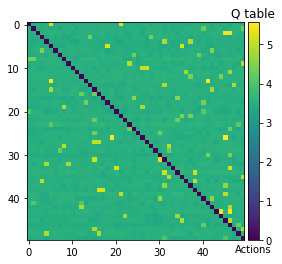

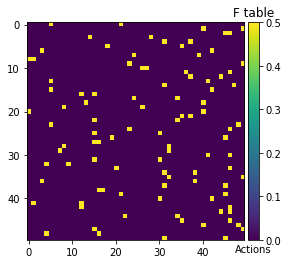

In [ ]:
RL_QF_2_T = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.1,
                         temperature=100,
                        #  custom = True
                        #end_decay=300_000,
                         #eps_threshold=15_000
                         )

time_train, episodes, steps, costs, all_rewards_n_T, all_penalties_n_T, all_f_n_T = update_T(env, 
                                                                                            RL_QF_2_T, 
                                                                                            max_iter = 100_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=True,
                                                                                            temp_decay=True,
                                                                                            )

print("Total number of episodes: ", episodes)
RL_QF_2_T.plot_q_table()
RL_QF_2_T.plot_f_table()


In [ ]:
RL_QF_2_T.T

#### ALGO-QF without Temperature Decay

In [ ]:
RL_QF_2_T_fixed = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=1e-6,
                        #  end_decay=100_000,
                         eps_threshold=10_000 
                         )

time_train, episodes, steps, costs, all_rewards_n_T_fixed, all_penalties_n_T_fixed, all_f_n_T_fixed = update_T(env, 
                                                                                                                RL_QF_2_T_fixed, 
                                                                                                                max_iter = 70_000,
                                                                                                                threshold = -1,
                                                                                                                eps_decay=True,
                                                                                                                temp_decay=False
                                                                                                                )
print("Total number of episodes: ", episodes)
RL_QF_2_T_fixed.plot_q_table()
RL_QF_2_T_fixed.plot_f_table()

#### ALGO-QF with the max update

In [ ]:
## With Max
RL_QF_2_Max = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=1e-6, 
                         useMax=True,
                        #  end_decay=300_000,
                         eps_threshold=25_000
                         )

time_train, episodes, steps, costs, all_rewards_n_Max, all_penalties_n_Max, all_f_n_Max = update_T(env, 
                                                                                                    RL_QF_2_Max, 
                                                                                                    max_iter = 70_000, 
                                                                                                    threshold = -1,
                                                                                                    eps_decay=True,
                                                                                                    temp_decay=False,
                                                                                                    )

print("Total number of episodes: ", episodes)
RL_QF_2_Max.plot_q_table()
# RL_QF_2_Max.plot_f_table()

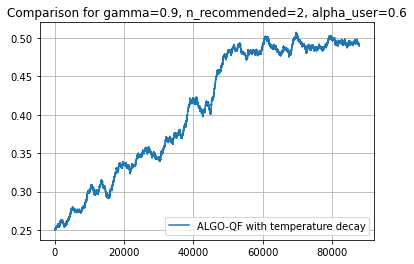

In [ ]:
smoothed_rews = running_mean(all_rewards_n_T, 2000)
plt.plot(smoothed_rews, label="ALGO-QF with temperature decay")

#smoothed_rews = running_mean(all_rewards_n_T_fixed, 2000)
#plt.plot(smoothed_rews, label="ALGO-QF without temperature decay")

#smoothed_rews = running_mean(all_rewards_n_Max, 2000)
#plt.plot(smoothed_rews, label="ALGO-QF with max")

#smoothed_rews = running_mean(all_rewards_eps, 2000)
#plt.plot(smoothed_rews, label="Oracle with epsilon decay")

#smoothed_rews = running_mean(all_rewards, 5000)
#plt.plot(smoothed_rews, label="Oracle without epsilon decay")

plt.legend()
plt.title(f"Comparison for gamma=0.9, n_recommended=2, alpha_user={env.alpha}")
plt.grid(True)


In [ ]:
#test with no exploration, after training

RL_2_eps.eps=0

time_train, episodes, steps, costs, all_rewards_eps, all_penalties_eps, all_f_eps = update(env, 
                                                                               RL_2_eps, 
                                                                               max_iter = 30_000, 
                                                                               threshold = -1,
                                                                               eps_decay=False
                                                                               )
#print("Total number of episodes: ", episodes)

RL_QF_2.eps=0

time_train, episodes, steps, costs, all_rewards_n, all_penalties_n, all_f_n = update_T(env, 
                                                                                       RL_QF_2, 
                                                                                       max_iter = 30_000, 
                                                                                       threshold = -1,
                                                                                       eps_decay=False,
                                                                                       temp_decay=False
                                                                                       )

RL_QF_2_T.eps=0

time_train, episodes, steps, costs, all_rewards_n_T, all_penalties_n_T, all_f_n_T = update_T(env, 
                                                                                       RL_QF_2_T, 
                                                                                       max_iter = 30_000, 
                                                                                       threshold = -1,
                                                                                       eps_decay=False,
                                                                                       temp_decay=False
                                                                                       )

In [ ]:
smoothed_rews = running_mean(all_rewards_n_T, 1000)
plt.plot(smoothed_rews, label="ALGO-QF temperature decay")

#smoothed_rews = running_mean(all_rewards_n_T_fixed, 1000)
#plt.plot(smoothed_rews, label="ALGO-QF without temperature decay")

#smoothed_rews = running_mean(all_rewards_eps, 1000)
#plt.plot(smoothed_rews, label="Tabular")

# smoothed_rews = running_mean(all_rewards, 2000)
# plt.plot(smoothed_rews, label="Tabular with epsilon decay")

plt.legend()
plt.title("Comparison for gamma=0.9, n_recommended=2")
plt.grid(True)

In [ ]:
plt.bar(np.arange(n_states), all_f, color='b', width=0.4,  )

plt.bar(np.arange(n_states)-0.4, all_f_n, color='r', width=0.4,  )



print("Cached items:")
for i in range(n_states):
  if env.cost[i] == 0:
    print(i)



In [ ]:
env = env_tmp

###Recommendation type check

In [ ]:
#RL = RL_2_eps
#RL_QF = RL_QF_2_T
RL = RL_1
RL_QF = RL_QF_1

n_states = n_states
n_actions = n_actions

env = env
cmp="single"

j=0
k=0
states=range(n_states)
both_t=np.zeros(n_states)
cached_t=np.zeros(n_states)
corr_t=np.zeros(n_states)
neither_t=np.zeros(n_states)
total_q_t=np.zeros(n_states)
both_qf =np.zeros(n_states)
cached_qf=np.zeros(n_states)
corr_qf=np.zeros(n_states)
neither_qf=np.zeros(n_states)
total_q_qf=np.zeros(n_states)
mask_both_not_both_qf = np.ones(n_states)

for i in range(n_states):
  if cmp == "multiple":
    a=RL.actions[np.argsort(RL.q_table[i])[-1]]
    b = np.argsort(RL_QF.q_table[i])[-RL_QF.N:]
    #print(f"Tabular q_matrix: state {i}: action {a}")
    #print(f"ALGO Q-L: state {i}: action {np.argsort(RL_QF.q_table[i])[-RL_QF.N:]}")
    recommended_matrix = env.recommended[i]
    total_q_t[i]=RL.q_table[i,np.argmax(RL.q_table[i])]
    for elem in a:
      is_cached = get_cached(elem, env.cost)
      if ( (elem in recommended_matrix) and (is_cached)) :
        both_t[i] += 1
      elif ( (elem in recommended_matrix) and ( not is_cached) ) :
        corr_t[i] += 1
      elif ( (elem not in recommended_matrix ) and (is_cached)) :
        cached_t[i] += 1
      else :
        neither_t[i] +=1
    for elem in b:
      total_q_qf[i] += RL_QF.q_table[i,elem]
      is_cached = get_cached(elem, env.cost)
      if ( (elem in recommended_matrix) and (is_cached)) :
        both_qf[i] += 1
        mask_both_not_both_qf[i]=0
      elif ( (elem in recommended_matrix) and ( not is_cached) ) :
        corr_qf[i] += 1
      elif ( (elem not in recommended_matrix ) and (is_cached)) :
        cached_qf[i] += 1
      else :
        neither_qf[i] +=1  
    if both_qf[i] > both_t[i]:
      print(f"found better solution at {i}")
    
    if both_qf[i] < both_t[i]:
      print(f"found worse solution at {i}")
  #print(f"Tabular q_matrix: {both_t[i]} both, {corr_t[i]} only corr, {cached_t[i]} cached only and {neither_t[i]} nothing")
  #print(f"ALGO Q-L: {both_qf[i]} both, {corr_qf[i]} only corr, {cached_qf[i]} cached only and {neither_qf[i]} nothing") 
  #print(f"Q comparison: {total_q_t} tabular; {total_q_qf/2} ALGO")
    '''
    if b[0] in a and b[1] in a:
      j+=1
    elif b[0] in a and b[1] not in a:
      k+=1
    elif b[1] in a and b[0] not in a:
      k+=1
    '''
  else:
    a=np.argsort(RL.q_table[i])[-1]
    b = np.argsort(RL_QF.q_table[i])[-RL_QF.N:]
    recommended_matrix = env.recommended[i]
    total_q_t[i]=RL.q_table[i,np.argmax(RL.q_table[i])]
    is_cached = get_cached(a, env.cost)
    if ( (a in recommended_matrix) and (is_cached)) :
      both_t[i] += 1
    elif ( (a in recommended_matrix) and ( not is_cached) ) :
      corr_t[i] += 1
    elif ( (a not in recommended_matrix ) and (is_cached)) :
      cached_t[i] += 1
    else :
      neither_t[i] +=1
    
    total_q_qf[i] += RL_QF.q_table[i,b]
    is_cached = get_cached(b, env.cost)
    if ( (b in recommended_matrix) and (is_cached)) :
      both_qf[i] += 1
      mask_both_not_both_qf[i]=0
    elif ( (b in recommended_matrix) and ( not is_cached) ) :
      corr_qf[i] += 1
    elif ( (b not in recommended_matrix ) and (is_cached)) :
      cached_qf[i] += 1
    else :
      neither_qf[i] +=1  
    if both_qf[i] > both_t[i]:
      print(f"found better solution at {i}")
    
    if both_qf[i] < both_t[i]:
      print(f"found worse solution at {i}")
    print(f"{i}:")  
    print(f"Tabular q_matrix ({a}): {both_t[i]} both, {corr_t[i]} only corr, {cached_t[i]} cached only and {neither_t[i]} nothing")
    print(f"ALGO Q-L ({b}): {both_qf[i]} both, {corr_qf[i]} only corr, {cached_qf[i]} cached only and {neither_qf[i]} nothing") 

  '''
  if b[0]==a:
    j += 1
  '''

total_q_qf = total_q_qf/RL_QF.N
#print(f"found {j} full matches and {k} partial matches out of {n_states}")

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(np.arange(n_states), total_q_qf, color='b', width=0.4,  )
ax.bar(np.arange(n_states)-0.4, total_q_t, color='r', width=0.4 )
ax.bar(np.arange(n_states), mask_both_not_both_qf, color='g', width=0.4,  )
ax.legend(["ALGO-QF", "Tabular", "both ALGO-QF suggestion only cached or corr"])
plt.title("Q-value of suggestions, given state. Gamma=0.9, n_recomm=1")

fig, bx = plt.subplots(figsize=(10,5))

bx.bar(["cached & correlated", "correlated only", "cached only", "none"], [np.sum(both_qf), np.sum(corr_qf), np.sum(cached_qf), np.sum(neither_qf)], width=0.4)
bx.bar(["cached & correlated", "correlated only", "cached only", "none"], [np.sum(both_t), np.sum(corr_t), np.sum(cached_t), np.sum(neither_t)],width=0.4, align="edge")
bx.legend(["ALGO-QF", "Tabular"])
plt.title("Class of recommendation done")


#print(f"found {j} full matches out of {n_states}")

### Comparision for n Recommendations

In [ ]:
RL_3 = Agent_n_recomm(
                      n_actions=n_actions,
                      n_states=n_states,
                      alpha=0.6, 
                      gamma = 0.9, 
                      eps=1, 
                      n_recomm=4
                      )

time_train_3, episodes_3, steps_3, costs_3, all_rewards_3, all_penalties_3, all_f_3 = update(env, 
                                                                                             RL_3, 
                                                                                             max_iter = 100_000, 
                                                                                             threshold = -1,
                                                                                             eps_decay=True
                                                                                           )
print("Total number of episodes: ", episodes_3)

RL_3.plot_q_table()


#### ALGO-QF without Temperature Decay

Total number of episodes:  150000


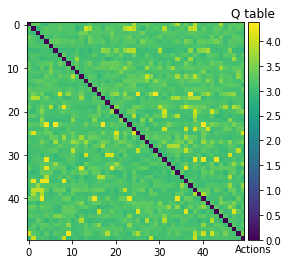

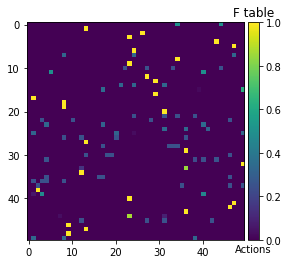

In [ ]:
## Without Temperature Decay
RL_QF_N_T_fixed = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=0.1, 
                         n_recommended=4,
                         delta=0.9,
                         temperature=1e-6,
                         end_decay=250_000,
                         eps_threshold=150_000 
                         )

time_train, episodes, steps, costs, all_rewards_n_T_fixed, all_penalties_n_T_fixed, all_f_n_T_fixed = update_T(env, 
                                                                                                                RL_QF_N_T_fixed, 
                                                                                                                max_iter = 150_000,
                                                                                                                #threshold = 0.005,
                                                                                                                eps_decay=False,
                                                                                                                temp_decay=False
                                                                                                                )
print("Total number of episodes: ", episodes)
RL_QF_N_T_fixed.plot_q_table()
RL_QF_N_T_fixed.plot_f_table()

#### ALGO-QF with Temperature Decay

Total number of episodes:  150000


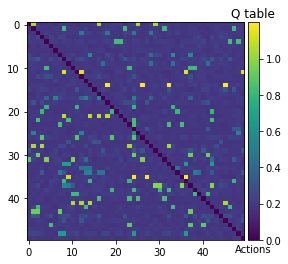

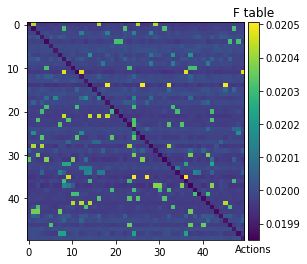

In [ ]:
## With Temperature Decay
RL_QF_N_T = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=0.1, 
                         n_recommended=4,
                         delta=0.1,
                         temperature=100,
                         end_decay=250_000,
                         eps_threshold=150_000
                         )

time_train, episodes, steps, costs, all_rewards_n_T, all_penalties_n_T, all_f_n_T = update_T(env, 
                                                                                            RL_QF_N_T, 
                                                                                            max_iter = 150_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=False,
                                                                                            temp_decay=True,
                                                                                            )

print("Total number of episodes: ", episodes)
RL_QF_N_T.plot_q_table()
RL_QF_N_T.plot_f_table()


#### ALGO-QF with Max


Total number of episodes:  150000


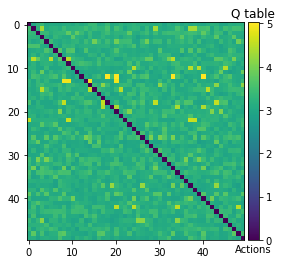

In [ ]:
## With Max
RL_QF_N_Max = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=0.1, 
                         n_recommended=4,
                         delta=0.9,
                         temperature=1e-6, 
                         useMax=True,
                         end_decay=250_000,
                         eps_threshold=150_000
                         )

time_train, episodes, steps, costs, all_rewards_n_Max, all_penalties_n_Max, all_f_n_Max = update_T(env, 
                                                                                                    RL_QF_N_Max, 
                                                                                                    max_iter = 150_000, 
                                                                                                    threshold = -1,
                                                                                                    eps_decay=False,
                                                                                                    temp_decay=False,
                                                                                                    )

print("Total number of episodes: ", episodes)
RL_QF_N_Max.plot_q_table()
# RL_QF_2_Max.plot_f_table()

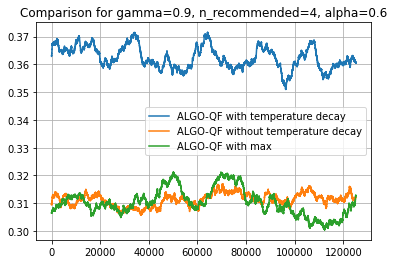

In [ ]:
smoothed_rews = running_mean(all_rewards_n_T, 10000)
plt.plot(smoothed_rews, label="ALGO-QF with temperature decay")

smoothed_rews = running_mean(all_rewards_n_T_fixed, 10000)
plt.plot(smoothed_rews, label="ALGO-QF without temperature decay")

smoothed_rews = running_mean(all_rewards_n_Max, 10000)
plt.plot(smoothed_rews, label="ALGO-QF with max")

plt.legend()
plt.title(f"Comparison for gamma=0.9, n_recommended=4, alpha={env.alpha}")
plt.grid(True)


In [ ]:
smoothed_rews = running_mean(all_rewards_n_3, 2000)
plt.plot(smoothed_rews, label="ALGO-QF")

smoothed_rews = running_mean(all_rewards_3, 2000)
plt.plot(smoothed_rews, label="Tabular Method")

plt.legend()
plt.title("comparison for gamma=0.9, n_recommended=3")
plt.grid(True)

In [ ]:
RL = RL_3
RL_QF = RL_QF_3

n_states = n_states2
n_actions = n_actions2

#env = env2
cmp="multiple"

j=0
k=0
states=range(n_states)
both_t=np.zeros(n_states)
cached_t=np.zeros(n_states)
corr_t=np.zeros(n_states)
neither_t=np.zeros(n_states)
total_q_t=np.zeros(n_states)
both_qf =np.zeros(n_states)
cached_qf=np.zeros(n_states)
corr_qf=np.zeros(n_states)
neither_qf=np.zeros(n_states)
total_q_qf=np.zeros(n_states)
mask_both_not_both_qf = np.ones(n_states)

for i in range(n_states):
  if cmp == "multiple":
    a=RL.actions[np.argsort(RL.q_table[i])[-1]]
    b = np.argsort(RL_QF.q_table[i])[-RL_QF.N:]
    #print(f"Tabular q_matrix: state {i}: action {a}")
    #print(f"ALGO Q-L: state {i}: action {np.argsort(RL_QF.q_table[i])[-RL_QF.N:]}")
    recommended_matrix = env.recommended[i]
    total_q_t[i]=RL.q_table[i,np.argmax(RL.q_table[i])]
    for elem in a:
      is_cached = get_cached(elem, env.cost)
      if ( (elem in recommended_matrix) and (is_cached)) :
        both_t[i] += 1
      elif ( (elem in recommended_matrix) and ( not is_cached) ) :
        corr_t[i] += 1
      elif ( (elem not in recommended_matrix ) and (is_cached)) :
        cached_t[i] += 1
      else :
        neither_t[i] +=1
    for elem in b:
      total_q_qf[i] += RL_QF.q_table[i,elem]
      is_cached = get_cached(elem, env.cost)
      if ( (elem in recommended_matrix) and (is_cached)) :
        both_qf[i] += 1
        mask_both_not_both_qf[i]=0
      elif ( (elem in recommended_matrix) and ( not is_cached) ) :
        corr_qf[i] += 1
      elif ( (elem not in recommended_matrix ) and (is_cached)) :
        cached_qf[i] += 1
      else :
        neither_qf[i] +=1  
    if both_qf[i] > both_t[i]:
      print(f"found better solution at {i}")
    
    if both_qf[i] < both_t[i]:
      print(f"found worse solution at {i}")
  #print(f"Tabular q_matrix: {both_t[i]} both, {corr_t[i]} only corr, {cached_t[i]} cached only and {neither_t[i]} nothing")
  #print(f"ALGO Q-L: {both_qf[i]} both, {corr_qf[i]} only corr, {cached_qf[i]} cached only and {neither_qf[i]} nothing") 
  #print(f"Q comparison: {total_q_t} tabular; {total_q_qf/2} ALGO")
    '''
    if b[0] in a and b[1] in a:
      j+=1
    elif b[0] in a and b[1] not in a:
      k+=1
    elif b[1] in a and b[0] not in a:
      k+=1
    '''
  else:
    a=np.argsort(RL.q_table[i])[-1]
    b = np.argsort(RL_QF.q_table[i])[-RL_QF.N:]
    recommended_matrix = env.recommended[i]
    total_q_t[i]=RL.q_table[i,np.argmax(RL.q_table[i])]
    is_cached = get_cached(a, env.cost)
    if ( (a in recommended_matrix) and (is_cached)) :
      both_t[i] += 1
    elif ( (a in recommended_matrix) and ( not is_cached) ) :
      corr_t[i] += 1
    elif ( (a not in recommended_matrix ) and (is_cached)) :
      cached_t[i] += 1
    else :
      neither_t[i] +=1
    
    total_q_qf[i] += RL_QF.q_table[i,b]
    is_cached = get_cached(b, env.cost)
    if ( (b in recommended_matrix) and (is_cached)) :
      both_qf[i] += 1
      mask_both_not_both_qf[i]=0
    elif ( (b in recommended_matrix) and ( not is_cached) ) :
      corr_qf[i] += 1
    elif ( (b not in recommended_matrix ) and (is_cached)) :
      cached_qf[i] += 1
    else :
      neither_qf[i] +=1  
    if both_qf[i] > both_t[i]:
      print(f"found better solution at {i}")
    
    if both_qf[i] < both_t[i]:
      print(f"found worse solution at {i}")
    print(f"{i}:")  
    print(f"Tabular q_matrix ({a}): {both_t[i]} both, {corr_t[i]} only corr, {cached_t[i]} cached only and {neither_t[i]} nothing")
    print(f"ALGO Q-L ({b}): {both_qf[i]} both, {corr_qf[i]} only corr, {cached_qf[i]} cached only and {neither_qf[i]} nothing") 

  '''
  if b[0]==a:
    j += 1
  '''

total_q_qf = total_q_qf/RL_QF.N
#print(f"found {j} full matches and {k} partial matches out of {n_states}")

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(np.arange(n_states), total_q_qf, color='b', width=0.4,  )
ax.bar(np.arange(n_states)-0.4, total_q_t, color='r', width=0.4 )
ax.bar(np.arange(n_states), mask_both_not_both_qf, color='g', width=0.4,  )
ax.legend(["ALGO-QF", "Tabular", "both ALGO-QF suggestion only cached or corr"])
plt.title("Q-value of suggestions, given state. Gamma=0.5")

fig, bx = plt.subplots(figsize=(10,5))

bx.bar(["cached & correlated", "correlated only", "cached only", "none"], [np.sum(both_qf), np.sum(corr_qf), np.sum(cached_qf), np.sum(neither_qf)], width=0.4)
bx.bar(["cached & correlated", "correlated only", "cached only", "none"], [np.sum(both_t), np.sum(corr_t), np.sum(cached_t), np.sum(neither_t)],width=0.4, align="edge")
bx.legend(["ALGO-QF", "Tabular"])
plt.title("Class of recommendation done")


#print(f"found {j} full matches out of {n_states}")

#####Previous tests

In [ ]:
RL_QF2 = Agent_Multiple(n_actions=n_actions,n_states=n_states, 
                        alpha=0.6, gamma = 0.9, eps=0.1, n_recommended=2, 
                       temperature=1_000, delta=0.9, custom=True )

time_train, episodes, steps, costs, all_rewards_n2, all_penalties_n2 = update_T(env, RL_QF2, max_iter = 100_000, threshold = 0.00000001)
print("Total number of episodes: ", episodes)
RL_QF2.plot_q_table()
#RL_QF2.plot_f_table()
print(RL_QF2.T)

In [ ]:
smoothed_rews = running_mean(all_rewards_n2, 5000)
plt.plot(smoothed_rews, label="new update")

smoothed_rews = running_mean(all_rewards_n, 5000)
plt.plot(smoothed_rews, label="old T update")

smoothed_rews = running_mean(all_rewards, 5000)
plt.plot(smoothed_rews, label="Tabular")

plt.legend()
plt.title("2 recommendations")
plt.grid(True)

In [ ]:
RL_QF3 = Agent_Multiple(n_actions=n_actions,n_states=n_states, 
                        alpha=0.6, gamma = 0.9, eps=0.1, n_recommended=2, 
                       temperature=10000, delta=0.6, custom=True)

time_train, episodes, steps, costs, all_rewards_n3, all_penalties_n3 = update_T(env, RL_QF3, max_iter = 100_000, threshold = 0.00000001)
print("Total number of episodes: ", episodes)
RL_QF3.plot_q_table()
#RL_QF3.plot_f_table()
print(RL_QF3.T)

In [ ]:
smoothed_rews = running_mean(all_rewards_n, 1000)
plt.plot(smoothed_rews, label="T0=500")

smoothed_rews = running_mean(all_rewards_n3, 1000)
plt.plot(smoothed_rews, label="T0=10_000")

smoothed_rews = running_mean(all_rewards_n2, 1000)
plt.plot(smoothed_rews, label="T0=1_000")

plt.legend()
plt.title("Different T0, T_final=e-30")
plt.grid(True)

In [ ]:
print(RL_QF.T)

### Plotting Rewards and Penalties

In [ ]:
env = Environment(
        n_actions=20,
        n_states=20,
        alpha=0.6, 
        to_leave=0.1, 
        n_recommended=8,
        n_cached=4,
        rewards = [2,1,1,0],
        SEED=777
    )

gamma_list = [0, 0.9]

reward_gamma, penalty_gamma, Agents = loop_gamma(env, alpha=0.2,epsilon=0.1,max_iter=100000, v1=False, threshold=0.0001, gammas=gamma_list, n_recomm=5)

In [ ]:
plot_reward_loss_gamma(reward_gamma,run_mean = 2000, gammas = gamma_list,name = 'Rewards')

In [ ]:
plot_reward_loss_gamma(penalty_gamma,run_mean = 10000, gammas = gamma_list,name = 'Penalties')

In [ ]:
Agents[0].plot_q_table()
Agents[0].plot_f_table()


In [ ]:
Agents[1].plot_q_table()
Agents[1].plot_f_table()

In [ ]:
Agents[1].gamma

In [ ]:
plot_notated_matrix(env.u, fig_size=(20, 20))

In [ ]:
from itertools import combinations
a = list(combinations(range(6),2))
print(a)


action=[]

q_table=[0,2,44,12,32,3,1,2,3,9,24,23,12,3,2]

index = np.argmax(q_table)
b = a[index] 
print(b)
for elem in b:
  action.append(elem)
print(action)

print(a.index((action[0],action[1])))

In [ ]:
RL_QF3 = Agent_Multiple(n_actions=n_actions,n_states=n_states, 
                        alpha=0.6, gamma = 0.9, eps=0.1, n_recommended=2, 
                       temperature=1000, delta=0.4, )

time_train, episodes, steps, costs, all_rewards_n3, all_penalties_n3 = update_T(env, RL_QF3, max_iter = 100_000, threshold = 0.00000001)
print("Total number of episodes: ", episodes)
RL_QF3.plot_q_table()
#RL_QF3.plot_f_table()
print(RL_QF3.T)

In [ ]:
RL_QF3.plot_f_table() 


In [ ]:
a = [1,(1,2),2,3,4]
b = [5,6,7,8]

np.concatenate((a,b))

In [ ]:
a.index((1,2))

In [ ]:
c  =tuple(b)

c

In [ ]:
a = [0,5,5,5,5]
np.argsort(a)

c = list(combinations(range(5), 2))
c

d= [2.5, 2.5, 2.5, 2.5, 5, 5, 5, 5, 5, 5]

i = np.argsort(d)[-1]

print(c[i])
print(np.argsort(a)[-2:])

## Class aware User (Sport vs Art)

In [ ]:
n_actions = 50
n_states = 50

u_classes = np.zeros([n_states,n_states])
for i in range(25):
  for j in range(25):
    if i != j:
      u_classes[i,j] = 1

for i in range(25,50):
  for j in range(25,50):
    if i != j:
      u_classes[i,j] = 1


env_class_sport = Environment(n_actions=n_actions, 
                              n_states=n_states, 
                              alpha=0.6, 
                              to_leave=0.1,
                              n_recommended=7, 
                              n_cached=5, 
                              rewards=[2,1,1,0], 
                              SEED=77, 
                              user_type="subset_interested",
                              choice_offset_start=0, 
                              choice_offset_end=25, 
                              u=u_classes)

env_class_art = Environment(n_actions=n_actions, 
                            n_states=n_states, 
                            alpha=0.6, 
                            to_leave=0.1,
                            n_recommended=7, 
                            n_cached=5, 
                            rewards=[2,1,1,0], 
                            SEED=77, 
                            user_type="subset_interested",
                            choice_offset_start=25, 
                            choice_offset_end=50, 
                            u=u_classes)

#RL.plot_results(steps, all_costs)

### 1 recommendation

####Random recommender

In [ ]:
'''
Agent class that always recommend a randomized item:
no learning here!

Used to get the mean reward in order to compare with our RL mean reward
Compare also costs and length of episodes
'''

class Randomic_choice:
  def __init__(self, n_states, n_actions, max_iter=50000):
    self.n_actions = n_actions
    self.n_states = n_states
    self.max_iter = max_iter
  

  def choose_action(self, state):
    action = []
    action.append(random.randint(0, self.n_actions-1))
    return np.array(action)          
            
  def update_random(self, env):
    """
    Parameters
    ---------
    env: Environment

    Returns
    -------
    time_train: time to execute the method
    episodes: total number of episodes runned 
    steps: steps performed for each episode
    costs: differences of errors between two episodes
    all_rewards: Average Rewards 
    all_penalties: Average penalties, defined as negative rewards
    
    """
    # Number of steps per episode
    steps = []
    
    episodes = 0
        
    before_time = time.time()
    
    all_rewards = []
    all_penalties = []
    
    while( (episodes < self.max_iter) ) :
        
        # Initialize the state
        state = env.refresh()
        i = 0
        
        done = False
        
        # Teacker for rewards and penalties
        current_reward = 0
        current_penalty = 0
        
        while not done:
            action = self.choose_action(state)
            
            next_state, reward, done = env.step(action, state)
            
            if ( (next_state is None) or (action is None)  ) :
                # We stop when the user leaves the process
                break

            # Go to the next state
            state = next_state
            
            # Calculating number of Steps in the current Episode
            i += 1
            
            # Append the Reward
            current_reward += reward
            
            # Define the penalty for negative rewards
            if reward == env.rewards[-1] : 
                current_penalty +=1
            
        steps += [i]
        episodes += 1
        
        # Append the rewards and Penalties
        if i != 0:
          all_penalties.append(current_penalty/(i))
          all_rewards.append(current_reward/(i))

        
        if episodes%1000 == 0 :
            print('Episodes : ', episodes, " / ", self.max_iter)
            clear_output(True)
        
    time_train =  time.time() - before_time

    return time_train, episodes, steps, all_rewards, all_penalties

In [ ]:
randomic_agent =  Randomic_choice(n_actions=n_actions,n_states=n_states, max_iter=100000)

time_train, episodes, steps, all_rewards_random, all_penalties_random = randomic_agent.update_random(env_class_sport)

#### Oracle

Total number of episodes:  80000


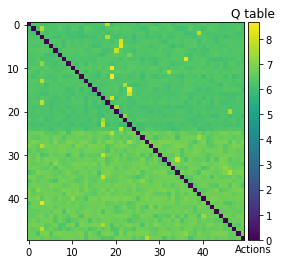

In [ ]:
RL_1_sport = Agent(n_actions=n_actions,
             n_states=n_states,
             alpha=0.6, 
             gamma = 0.9, 
             eps=1,
             )

time_train, episodes, steps, costs, all_rewards_1_s, all_penalties_1, all_f_1 = update(env_class_sport, 
                                                                               RL_1_sport, 
                                                                               max_iter = 80_000, 
                                                                               threshold = -1,
                                                                               eps_decay=True
                                                                               )
print("Total number of episodes: ", episodes)

RL_1_sport.plot_q_table()

Total number of episodes:  80000


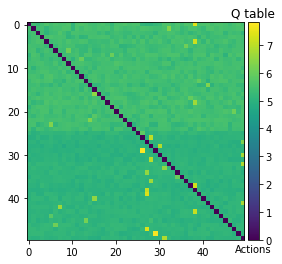

In [ ]:
RL_1_art = Agent(n_actions=n_actions,
             n_states=n_states,
             alpha=0.6, 
             gamma = 0.9, 
             eps=1,
             )

time_train, episodes, steps, costs, all_rewards_1_a, all_penalties_1, all_f_1 = update(env_class_art, 
                                                                               RL_1_art, 
                                                                               max_iter = 80_000, 
                                                                               threshold = -1,
                                                                               eps_decay=True
                                                                               )
print("Total number of episodes: ", episodes)

RL_1_art.plot_q_table()

#### ALGO-QF (single recomm)

Total number of episodes:  80000


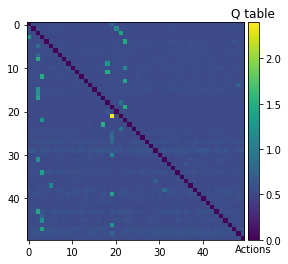

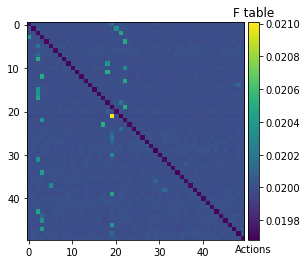

In [ ]:
RL_QF_1_sport = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9,
                         delta=0.1, 
                         eps=1, 
                         n_recommended=1,
                         )

time_train, episodes, steps, costs, all_rewards_n_1_s, all_penalties_n_1, all_f_n_1 = update_T(env_class_sport, 
                                                                                       RL_QF_1_sport, 
                                                                                       max_iter = 80_000, 
                                                                                       threshold = -1,
                                                                                       temp_decay=True,
                                                                                       eps_decay=True
                                                                                       )
print("Total number of episodes: ", episodes)
RL_QF_1_sport.plot_q_table()
RL_QF_1_sport.plot_f_table()

Total number of episodes:  80000


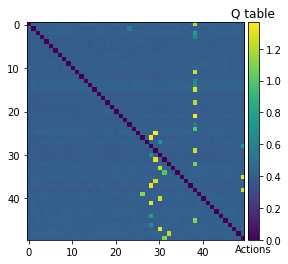

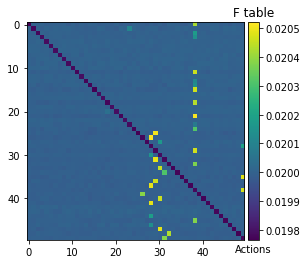

In [ ]:
RL_QF_1_art = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         delta=0.1,
                         eps=1, 
                         n_recommended=1,
                         )

time_train, episodes, steps, costs, all_rewards_n_1_a, all_penalties_n_1, all_f_n_1 = update_T(env_class_art, 
                                                                                       RL_QF_1_art, 
                                                                                       max_iter = 80_000, 
                                                                                       threshold = -1,
                                                                                       temp_decay=True,
                                                                                       eps_decay=True
                                                                                       )
print("Total number of episodes: ", episodes)
RL_QF_1_art.plot_q_table()
RL_QF_1_art.plot_f_table()

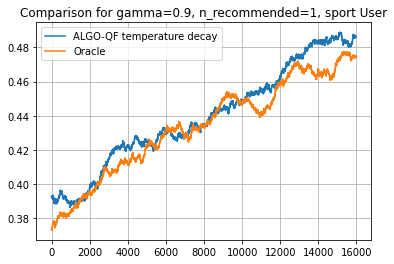

In [ ]:
smoothed_rews = running_mean(all_rewards_n_1_s, 2000)
plt.plot(smoothed_rews, label="ALGO-QF temperature decay")

#smoothed_rews = running_mean(all_rewards_n_T_fixed, 1000)
#plt.plot(smoothed_rews, label="ALGO-QF without temperature decay")

smoothed_rews = running_mean(all_rewards_1_s, 2000)
plt.plot(smoothed_rews, label="Oracle")

#smoothed_rews = running_mean(all_rewards_random, 2000)
#plt.plot(smoothed_rews, label="Random recommender")

# smoothed_rews = running_mean(all_rewards, 2000)
# plt.plot(smoothed_rews, label="Tabular with epsilon decay")

plt.legend()
plt.title("Comparison for gamma=0.9, n_recommended=1, sport User")
plt.grid(True)

In [ ]:
all_f_n_1

###Class user, 2 recommendations

####Oracle

In [ ]:
#With Epsilon Decay
RL_2_eps_s = Agent_n_recomm(
                      n_actions=n_actions,
                      n_states=n_states,
                      alpha=0.6, 
                      gamma = 0.9, 
                      eps=1, 
                      n_recomm=2,
                      # end_decay=300_000,
                      # eps_threshold=100_000
                      # custom=True
                      )

time_train, episodes, steps, costs, all_rewards_eps_s, all_penalties_eps, all_f_eps = update(env_class_sport, 
                                                                                            RL_2_eps_s, 
                                                                                            max_iter = 100_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=True
                                                                                            )

print("Total number of episodes: ", episodes)

RL_2_eps_s.plot_q_table()


#### ALGO-QF

In [ ]:
RL_QF_2_T_s = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=100,
                        #  custom = True
                        #  end_decay=300_000,
                        #eps_threshold=6_000
                         )

time_train, episodes, steps, costs, all_rewards_n_T_s, all_penalties_n_T, all_f_n_T = update_T(env_class_sport, 
                                                                                            RL_QF_2_T_s, 
                                                                                            max_iter = 100_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=True,
                                                                                            temp_decay=True,
                                                                                            )

print("Total number of episodes: ", episodes)
RL_QF_2_T_s.plot_q_table()
RL_QF_2_T_s.plot_f_table()


#### ALGO-QF fixed Temperature

In [ ]:
RL_QF_2_T_fixed_s = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=1e-6,
                        #  end_decay=100_000,
                         #eps_threshold=_000 
                         )

time_train, episodes, steps, costs, all_rewards_n_T_fixed_s, all_penalties_n_T_fixed, all_f_n_T_fixed = update_T(env_class_sport, 
                                                                                                                RL_QF_2_T_fixed_s, 
                                                                                                                max_iter = 100_000,
                                                                                                                threshold = -1,
                                                                                                                eps_decay=True,
                                                                                                                temp_decay=False
                                                                                                                )
print("Total number of episodes: ", episodes)
RL_QF_2_T_fixed_s.plot_q_table()
RL_QF_2_T_fixed_s.plot_f_table()

####ALGO-QF with Max

In [ ]:
## With Max
RL_QF_2_Max_s = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=1e-6, 
                         useMax=True,
                        #  end_decay=300_000,
                         #eps_threshold=7_000
                         )

time_train, episodes, steps, costs, all_rewards_n_Max_s, all_penalties_n_Max, all_f_n_Max = update_T(env_class_sport, 
                                                                                                    RL_QF_2_Max_s, 
                                                                                                    max_iter = 100_000, 
                                                                                                    threshold = -1,
                                                                                                    eps_decay=True,
                                                                                                    temp_decay=False,
                                                                                                    )

print("Total number of episodes: ", episodes)
RL_QF_2_Max_s.plot_q_table()
# RL_QF_2_Max.plot_f_table()

In [ ]:
smoothed_rews = running_mean(all_rewards_n_T_s, 1000)
plt.plot(smoothed_rews, label="ALGO-QF with temperature decay")

smoothed_rews = running_mean(all_rewards_n_T_fixed_s, 1000)
plt.plot(smoothed_rews, label="ALGO-QF without temperature decay")

smoothed_rews = running_mean(all_rewards_n_Max_s, 1000)
plt.plot(smoothed_rews, label="ALGO-QF with max")

smoothed_rews = running_mean(all_rewards_eps_s, 2000)
plt.plot(smoothed_rews, label="Oracle with epsilon decay")


plt.legend()
plt.title(f"Comparison for gamma=0.9, n_recommended=2, art user")
plt.grid(True)

#### Check class recommended

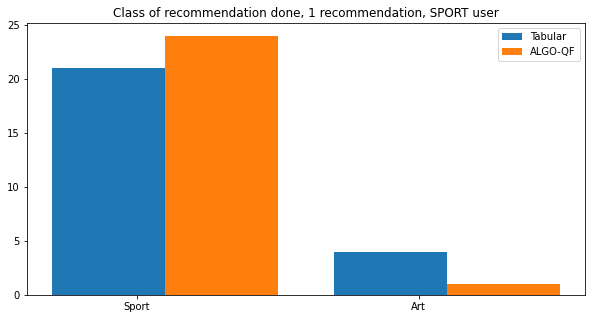

In [ ]:
TYPE = "SPORT" 
#TYPE = "ART"

COMPARISON = "RESTRICTED"

if TYPE == "SPORT":
  env = env_class_sport
elif TYPE == "ART":
  env = env_class_art

start_offset= env.choice_offset_start;
end_offset = env.choice_offset_end
cmp="single"

j=0
k=0
sport_t=0
art_t=0
sport_qf=0
art_qf=0
sport_qf_t_fixed=0
art_qf_t_fixed =0
sport_qf_max=0
art_qf_max=0

#for i in range(n_states):
for i in range(start_offset, end_offset):

  if cmp == "multiple":
    if TYPE == "SPORT": 
      RL = RL_2_eps_s
      RL_QF_TFIXED = RL_QF_2_T_fixed_s
      RL_QF = RL_QF_2_T_s
      RL_QF_MAX = RL_QF_2_Max_s
    else:
      RL = RL_2_eps_s
      RL_QF_TFIXED = RL_QF_2_T_fixed_s
      RL_QF = RL_QF_2_T_s
      RL_QF_MAX = RL_QF_2_Max_s
    a=RL.actions[np.argsort(RL.q_table[i])[-1]]
    b = np.argsort(RL_QF.q_table[i])[-RL_QF.N:]
    c = np.argsort(RL_QF_TFIXED.q_table[i])[-RL_QF_TFIXED.N:]
    d = np.argsort(RL_QF_MAX.q_table[i])[-RL_QF_MAX.N:]
    
    for elem in a:
      if elem <25:
        sport_t +=1
      else:
        art_t +=1
    for elem in b:
      if elem <25:
        sport_qf +=1
      else:
        art_qf +=1
    for elem in c:
      if elem <25:
        sport_qf_t_fixed +=1
      else:
        art_qf_t_fixed +=1
    for elem in d:
      if elem <25:
        sport_qf_max +=1
      else:
        art_qf_max +=1
    
  else:
    if TYPE == "SPORT": 
      RL = RL_1_sport
      RL_QF = RL_QF_1_sport 
    elif TYPE == "ART":
      RL = RL_1_art
      RL_QF = RL_QF_1_art 
    a=np.argsort(RL.q_table[i])[-1]
    b = np.argsort(RL_QF.q_table[i])[-RL_QF.N:]
    if a <25:
      sport_t +=1
    else:
      art_t +=1
    if b <25:
      sport_qf +=1
    else:
      art_qf +=1

labels=["Sport", "Art"]
x = np.arange(len(labels))
if cmp == "multiple":
  fig, bx = plt.subplots(figsize=(10,5))
  
  bx.bar(x-0.2, [sport_t, art_t], width=0.2)
  bx.bar(x-0.1, [sport_qf, art_qf], width=0.2, align="edge")
  bx.bar(x+0.1, [sport_qf_t_fixed, art_qf_t_fixed], width=0.2, align="edge")
  bx.bar(x+0.3, [sport_qf_max, art_qf_max], width=0.2, align="edge")

  bx.set_xticks(x)
  bx.set_xticklabels(labels)
  bx.legend(["Tabular", "ALGO-QF", "ALGO-QF with T fixed", "ALGO-QF with max"])
  plt.title(f"Class of recommendation done, {len(a)} recommendation, {TYPE} user")
else:
  fig, bx = plt.subplots(figsize=(10,5))

  bx.bar(x-0.1, [sport_t, art_t], width=0.4)
  bx.bar(x+0.1, [sport_qf, art_qf], width=0.4, align="edge")
  
  bx.set_xticks(x)
  bx.set_xticklabels(labels)
  bx.legend(["Tabular", "ALGO-QF"])
  plt.title(f"Class of recommendation done, 1 recommendation, {TYPE} user")



## Temperature Tuning

In [ ]:
n_actions = 50
n_states = 50

env_T = Environment(n_actions=n_actions, 
                  n_states=n_states, 
                  alpha=0.6, 
                  to_leave=0.1,
                  n_recommended=7, 
                  n_cached=5, 
                  rewards=[2,1,1,0], 
                  SEED=77)

#RL.plot_results(steps, all_costs)

### Normal ALGO-QF with temperature decay

In [ ]:
RL_QF_2_T = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=100,
                         )

time_train, episodes, steps, costs, all_rewards_n_T, all_penalties_n_T, all_f_n_T = update_T(env_T, 
                                                                                            RL_QF_2_T, 
                                                                                            max_iter = 100_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=True,
                                                                                            temp_decay=True,
                                                                                            )

print("Total number of episodes: ", episodes)
RL_QF_2_T.plot_q_table()
RL_QF_2_T.plot_f_table()

### Linear Temperature Decay

In [ ]:
RL_QF_2_L = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=1000,
                        #  custom = True
                         )

time_train, episodes, steps, costs, all_rewards_n_L, all_penalties_n_L, all_f_n_L = update_T(env_T, 
                                                                                            RL_QF_2_L, 
                                                                                            max_iter = 100_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=True,
                                                                                            temp_decay=True,
                                                                                            )

print("Total number of episodes: ", episodes)
RL_QF_2_L.plot_q_table()
RL_QF_2_L.plot_f_table()

### Another Delta Value

In [ ]:
RL_QF_2_A = Agent_Multiple(n_actions=n_actions,
                         n_states=n_states, 
                         alpha=0.6, 
                         gamma = 0.9, 
                         eps=1, 
                         n_recommended=2,
                         delta=0.9,
                         temperature=10,
                        #  custom = True
                         )

time_train, episodes, steps, costs, all_rewards_n_A, all_penalties_n_A, all_f_n_A = update_T(env_T, 
                                                                                            RL_QF_2_A, 
                                                                                            max_iter = 100_000, 
                                                                                            threshold = -1,
                                                                                            eps_decay=True,
                                                                                            temp_decay=True,
                                                                                            )

print("Total number of episodes: ", episodes)
RL_QF_2_A.plot_q_table()
RL_QF_2_A.plot_f_table()

### Plot Comparison

In [ ]:
smoothed_rews = running_mean(all_rewards_n_T, 5_000)
plt.plot(smoothed_rews, label="T_0 = 100")

smoothed_rews = running_mean(all_rewards_n_L, 5_000)
plt.plot(smoothed_rews, label="T_0 = 1000")

smoothed_rews = running_mean(all_rewards_n_A, 5_000)
plt.plot(smoothed_rews, label="T_0 = 10")


plt.legend()
plt.title("Comparison of ALGO-QF for Different Starting Temperatures, Delta=0.9")
plt.grid(True)

In [ ]:
RL_QF_2_A.T